In [1]:
%pip install scikit-learn seaborn dgl -f https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Looking in links: https://data.dgl.ai/wheels/torch-2.4/cu124/repo.html
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install tensorboard

Looking in indexes: https://mirrors.tuna.tsinghua.edu.cn/pypi/web/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
from dgl.data.utils import load_graphs
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [4]:
has_data = True
SAVE = True
TRAINING_STAGE1_EPOCH = 300
TRAINING_STAGE2_EPOCH = 600

## Load Training Data

In [ ]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Training.csv")
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

print("总样本数:", len(data))
print("字段:", data.columns.tolist())
print(data["category"].value_counts())  # 看攻击类别分布

总样本数: 2934817
字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
category
DDoS              1541315
DoS               1320148
Reconnaissance      72919
Normal                370
Theft                  65
Name: count, dtype: int64


In [ ]:
le = LabelEncoder()
le.fit_transform(data.category.values)
data["category"] = le.transform(data["category"])
data["category"].value_counts()

category
0    1541315
1    1320148
3      72919
2        370
4         65
Name: count, dtype: int64

In [ ]:
le.fit_transform(data.proto.values)
data["proto"] = le.transform(data["proto"])
data["proto"].value_counts()

proto
4    1596819
3    1330598
1       7228
0        166
2          6
Name: count, dtype: int64

In [ ]:
data["saddr"] = data.saddr.apply(str)
data["daddr"] = data.daddr.apply(str)
data["saddr"] = data.saddr.apply(
    lambda x: socket.inet_ntoa(
        struct.pack(">I", random.randint(0xAC100001, 0xAC1F0001))
    )
)

data = data.reset_index()
data.replace([np.inf, -np.inf], np.nan, inplace=True)

data.fillna(0, inplace=True)

data.drop(columns=["index"], inplace=True)

print("字段:", data.columns.tolist())
print("Shape: ", data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [9]:
data

,pkSeqID,proto,saddr,sport,daddr,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack,category,subcategory
0,3142762,4,172.22.184.87,6551,192.168.100.3,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1,0,UDP
1,2432264,3,172.22.116.87,5532,192.168.100.3,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1,0,TCP
2,1976315,3,172.20.125.213,27165,192.168.100.3,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1,0,TCP
3,1240757,4,172.24.117.15,48719,192.168.100.3,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1,1,UDP
4,3257991,4,172.24.86.200,22461,192.168.100.3,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1,0,UDP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,4,172.18.205.18,56044,192.168.100.5,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1,1,UDP
2934813,3384621,4,172.22.64.84,21546,192.168.100.3,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1,0,UDP
2934814,775893,4,172.25.237.132,30897,192.168.100.5,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1,1,UDP
2934815,443484,3,172.25.112.28,36904,192.168.100.7,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1,1,TCP


In [10]:
labels = data["category"]
labels

0          0
1          0
2          0
3          1
4          0
          ..
2934812    1
2934813    0
2934814    1
2934815    1
2934816    1
Name: category, Length: 2934817, dtype: int64

In [ ]:
features = data.drop(columns=["category", "subcategory"])
features = features.drop(["saddr", "daddr"], axis=1)
features

,pkSeqID,proto,sport,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,3142762,4,6551,80,251984,1.900363,100,0.000000,4,2.687519,100,0.000000,0.494549,4.031619,1
1,2432264,3,5532,80,256724,0.078003,38,3.856930,3,3.934927,100,0.000000,0.256493,4.012924,1
2,1976315,3,27165,80,62921,0.268666,100,2.974100,3,3.341429,100,0.000000,0.294880,3.609205,1
3,1240757,4,48719,80,99168,1.823185,63,0.000000,4,3.222832,63,0.000000,0.461435,4.942302,1
4,3257991,4,22461,80,105063,0.822418,100,2.979995,4,3.983222,100,0.000000,1.002999,4.994452,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,1132803,4,56044,80,253370,0.016992,100,4.082509,4,4.102515,100,0.000000,0.243473,4.124047,1
2934813,3384621,4,21546,80,231693,1.922317,100,0.000000,4,2.718527,100,0.000000,0.490800,4.090534,1
2934814,775893,4,30897,80,158616,2.112228,100,0.000000,4,2.110766,100,0.000000,0.207444,4.332615,1
2934815,443484,3,36904,80,179855,0.000000,100,0.000000,3,0.000000,100,0.000000,0.162130,0.000000,1


In [12]:
print("字段:", features.columns.tolist())
print("Shape: ", features.columns.shape)

字段: ['pkSeqID', 'proto', 'sport', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack']
Shape:  (15,)


In [13]:
num_features = features.select_dtypes(include=[np.number])
features_array = num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
labels_array = labels.values.astype(np.int64)  # 如果标签是整数型，可以使用 np.long 类型

In [14]:
features_array.shape

(2934817, 13)

In [15]:
labels_array.shape

(2934817,)

In [16]:
scaler = StandardScaler()
standardized_data = scaler.fit_transform(features_array)
min_max_scaler = MinMaxScaler()
normalized_data = min_max_scaler.fit_transform(standardized_data)

In [ ]:
import torch

features_tensor = torch.tensor(normalized_data, dtype=torch.float32)
labels_tensor = torch.tensor(
    labels_array, dtype=torch.long
)  # 如果标签是整数型，可以使用 torch.long 类型

In [ ]:
features_tensor = pd.concat(
    [
        data[["saddr", "daddr"]].reset_index(drop=True),
        pd.DataFrame(features_tensor.numpy()),
    ],
    axis=1,
)

In [19]:
X_train = features_tensor
y_train = labels_tensor

In [ ]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns)) - set(list(["label"])))
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [ ]:
X_train["label"] = y_train
X_train["h"] = X_train[cols_to_norm].values.tolist()

In [22]:
X_train

,saddr,daddr,0,1,2,3,4,5,6,7,8,9,10,11,12,label,h
0,172.22.184.87,192.168.100.3,1.235583,0.897328,1.724395,1.261013,0.715453,-0.685658,0.729321,0.301132,0.415178,-0.007652,-0.003357,0.544007,0.011229,0,"[1.2355825901031494, 0.8973283767700195, 1.724..."
1,172.22.116.87,192.168.100.3,0.564705,-1.049143,1.786939,-1.006622,-1.826553,1.914139,-0.113064,1.123003,0.415178,-0.007652,-0.003660,0.533961,0.011229,0,"[0.5647051334381104, -1.0491434335708618, 1.78..."
2,172.20.125.213,192.168.100.3,0.134182,-1.049143,-0.770268,-0.769373,0.715453,1.319060,-0.113064,0.731969,0.415178,-0.007652,-0.003612,0.317014,0.011229,0,"[0.13418172299861908, -1.0491434335708618, -0...."
3,172.24.117.15,192.168.100.3,-0.560358,0.897328,-0.291994,1.164977,-0.801551,-0.685658,0.729321,0.653830,-1.621537,-0.007652,-0.003399,1.033381,0.011229,1,"[-0.5603584051132202, 0.8973283767700195, -0.2..."
4,172.24.86.200,192.168.100.3,1.344386,0.897328,-0.214210,-0.080317,0.715453,1.323033,0.729321,1.154823,0.415178,-0.007652,-0.002709,1.061404,0.011229,0,"[1.3443859815597534, 0.8973283767700195, -0.21..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2934812,172.18.205.18,192.168.100.5,-0.662292,0.897328,1.742683,-1.082541,0.715453,2.066192,0.729321,1.233421,0.415178,-0.007652,-0.003677,0.593675,0.011229,1,"[-0.6622923612594604, 0.8973283767700195, 1.74..."
2934813,172.22.64.84,192.168.100.3,1.463955,0.897328,1.456657,1.288331,0.715453,-0.685658,0.729321,0.321562,0.415178,-0.007652,-0.003362,0.575666,0.011229,0,"[1.4639545679092407, 0.8973283767700195, 1.456..."
2934814,172.25.237.132,192.168.100.5,-0.999300,0.897328,0.492415,1.524645,0.715453,-0.685658,0.729321,-0.078869,0.415178,-0.007652,-0.003723,0.705753,0.011229,1,"[-0.9992995858192444, 0.8973283767700195, 0.49..."
2934815,172.25.112.28,192.168.100.7,-1.313172,-1.049143,0.772662,-1.103685,0.715453,-0.685658,-0.113064,-1.469575,0.415178,-0.007652,-0.003781,-1.622465,0.011229,1,"[-1.3131719827651978, -1.0491434335708618, 0.7..."


In [ ]:
if has_data:
    from dgl.data.utils import load_graphs

    G = load_graphs("./data.bin")[0][0]
else:
    G = nx.from_pandas_edgelist(
        X_train, "saddr", "daddr", ["h", "label"], create_using=nx.MultiGraph()
    )
    G = G.to_directed()
    G = from_networkx(G, edge_attrs=["h", "label"])
    # Eq1
    G.ndata["h"] = th.ones(G.num_nodes(), G.edata["h"].shape[1])
    G.ndata["h"] = th.reshape(
        G.ndata["h"], (G.ndata["h"].shape[0], 1, G.ndata["h"].shape[1])
    )
    G.edata["h"] = th.reshape(
        G.edata["h"], (G.edata["h"].shape[0], 1, G.edata["h"].shape[1])
    )
    G.edata["train_mask"] = th.ones(len(G.edata["h"]), dtype=th.bool)
    from dgl.data.utils import save_graphs

    save_graphs("./data.bin", [G])

In [ ]:
node_features = G.ndata["h"]
edge_features = G.edata["h"]

edge_label = G.edata["label"]
train_mask = G.edata["train_mask"]
train_mask = train_mask.bool()

print(node_features.shape)
print(edge_features.shape)

torch.Size([933261, 1, 13])
torch.Size([5869634, 1, 13])


In [ ]:
node_features = node_features.cuda()
edge_features = edge_features.cuda()
edge_label = edge_label.cuda()
train_mask = train_mask.cuda()
G = G.to("cuda")

In [ ]:
print(f"Node feature shape: {node_features.shape}")
print(f"Edge feature shape: {edge_features.shape}")

# 假设输出是:
# Node feature shape: [N, 1, A]  -> A是实际的节点维度
# Edge feature shape: [E, 1, B]  -> B是实际的边的维度

A_actual = node_features.shape[2]  # 实际节点维度
B_actual = edge_features.shape[2]  # 实际边维度

Node feature shape: torch.Size([933261, 1, 13])
Edge feature shape: torch.Size([5869634, 1, 13])


In [ ]:
# 获取实际的特征维度
actual_node_dim = node_features.shape[2]
actual_edge_dim = edge_features.shape[2]

## Load Testing Data

In [ ]:
# data = pd.read_csv('./bot.csv')
import pandas as pd
from glob import glob

# 读取所有 Full5pc 的 CSV（例如 Full5pc_1, Full5pc_2, ...）
test_files = glob("./bot/UNSW_2018_IoT_Botnet_Final_10_best_Testing.csv")
test_dfs = [pd.read_csv(f) for f in test_files]
test_data = pd.concat(test_dfs, ignore_index=True)

print("总样本数:", len(test_data))
print("字段:", test_data.columns.tolist())
print(test_data["category"].value_counts())  # 看攻击类别分布

总样本数: 733705
字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
category
DDoS              385309
DoS               330112
Reconnaissance     18163
Normal               107
Theft                 14
Name: count, dtype: int64


In [ ]:
le = LabelEncoder()
le.fit_transform(test_data.category.values)
test_data["category"] = le.transform(test_data["category"])

In [ ]:
le.fit_transform(test_data.proto.values)
test_data["proto"] = le.transform(test_data["proto"])

In [ ]:
test_data["saddr"] = test_data.saddr.apply(str)
test_data["daddr"] = test_data.daddr.apply(str)
test_data["saddr"] = test_data.saddr.apply(
    lambda x: socket.inet_ntoa(
        struct.pack(">I", random.randint(0xAC100001, 0xAC1F0001))
    )
)
test_data = test_data.reset_index()
test_data.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data.fillna(0, inplace=True)
test_data.drop(columns=["index"], inplace=True)
print("字段:", test_data.columns.tolist())
print("Shape: ", test_data.columns.shape)

字段: ['pkSeqID', 'proto', 'saddr', 'sport', 'daddr', 'dport', 'seq', 'stddev', 'N_IN_Conn_P_SrcIP', 'min', 'state_number', 'mean', 'N_IN_Conn_P_DstIP', 'drate', 'srate', 'max', 'attack', 'category', 'subcategory']
Shape:  (19,)


In [ ]:
test_features = test_data.drop(columns=["category", "subcategory"])
test_features = test_features.drop(["saddr", "daddr"], axis=1)
test_features

,pkSeqID,proto,sport,dport,seq,stddev,N_IN_Conn_P_SrcIP,min,state_number,mean,N_IN_Conn_P_DstIP,drate,srate,max,attack
0,792371,4,48516,80,175094,0.226784,100,4.100436,4,4.457383,100,0.000000,0.404711,4.719438,1
1,2056418,3,22267,80,143024,0.451998,100,3.439257,1,3.806172,100,0.225077,0.401397,4.442930,1
2,2795650,4,28629,80,167033,1.931553,73,0.000000,4,2.731204,100,0.000000,0.407287,4.138455,1
3,2118009,3,42142,80,204615,0.428798,56,3.271411,1,3.626428,100,0.000000,0.343654,4.229700,1
4,303688,3,1645,80,40058,2.058381,100,0.000000,3,1.188407,100,0.000000,0.135842,4.753628,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733700,1571905,4,17412,80,168162,1.743940,39,0.000000,4,3.020449,39,0.000000,0.224603,4.043432,1
733701,2787099,4,932,80,158482,0.694618,65,3.002272,4,3.905409,100,0.000000,0.875121,4.691634,1
733702,2255382,3,47980,80,79841,1.744651,53,0.000000,1,2.464288,100,0.278496,0.472773,3.802142,1
733703,588946,3,25096,80,63165,0.000000,100,0.000000,3,0.000000,100,0.000000,0.070461,0.000000,1


In [33]:
test_labels = test_data["category"]
test_labels

0         1
1         0
2         0
3         0
4         1
         ..
733700    1
733701    0
733702    0
733703    1
733704    0
Name: category, Length: 733705, dtype: int64

In [ ]:
test_num_features = test_features.select_dtypes(include=[np.number])
test_features_array = test_num_features.values.astype(np.float32)

# features_array = features.values.astype(np.float32)
test_labels_array = test_labels.values.astype(
    np.int64
)  # 如果标签是整数型，可以使用 np.long 类型

In [35]:
test_features_array.shape

(733705, 13)

In [36]:
test_labels_array.shape

(733705,)

In [37]:
scaler = StandardScaler()
test_standardized_data = scaler.fit_transform(test_features_array)
min_max_scaler = MinMaxScaler()
test_normalized_data = min_max_scaler.fit_transform(test_standardized_data)

In [ ]:
import torch

test_features_tensor = torch.tensor(test_normalized_data, dtype=torch.float32)
test_labels_tensor = torch.tensor(
    test_labels_array, dtype=torch.long
)  # 如果标签是整数型，可以使用 torch.long 类型

In [ ]:
test_features_tensor = pd.concat(
    [
        test_data[["saddr", "daddr"]].reset_index(drop=True),
        pd.DataFrame(test_features_tensor.numpy()),
    ],
    axis=1,
)

In [40]:
X_test = test_features_tensor
y_test = test_labels_tensor

In [ ]:
test_cols_to_norm = list(set(list(X_test.iloc[:, 2:].columns)) - set(list(["label"])))
X_test[test_cols_to_norm] = scaler.fit_transform(X_test[test_cols_to_norm])

In [ ]:
X_test["label"] = y_test
X_test["h"] = X_test[test_cols_to_norm].values.tolist()

In [43]:
X_test

,saddr,daddr,0,1,2,3,4,5,6,7,8,9,10,11,12,label,h
0,172.20.240.224,192.168.100.3,-0.984205,0.896043,0.707977,-0.822263,0.716751,2.076200,0.729019,1.465469,0.415690,-0.006811,-0.004605,0.911708,0.012077,1,"[-0.9842054843902588, 0.8960432410240173, 0.70..."
1,172.30.232.58,192.168.100.3,0.209615,-1.049722,0.285020,-0.542151,0.716751,1.630732,-1.799584,1.036355,0.415690,-0.003783,-0.004613,0.763106,0.012077,0,"[0.20961512625217438, -1.04972243309021, 0.285..."
2,172.21.130.204,192.168.100.3,0.907778,0.896043,0.601664,1.298064,-0.388623,-0.686460,0.729019,0.328007,0.415690,-0.006811,-0.004599,0.599473,0.012077,0,"[0.9077776074409485, 0.8960432410240173, 0.601..."
3,172.18.47.16,192.168.100.3,0.267784,-1.049722,1.097316,-0.571006,-1.084599,1.517646,-1.799584,0.917913,0.415690,-0.006811,-0.004756,0.648511,0.012077,0,"[0.26778411865234375, -1.04972243309021, 1.097..."
4,172.19.5.24,192.168.100.5,-1.445739,-1.049722,-1.072952,1.455808,0.716751,-0.686460,-0.113849,-0.688615,0.415690,-0.006811,-0.005271,0.930083,0.012077,1,"[-1.445738673210144, -1.04972243309021, -1.072..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
733700,172.24.80.223,192.168.100.6,-0.247980,0.896043,0.616554,1.064718,-1.780575,-0.686460,0.729019,0.518605,-2.933002,-0.006811,-0.005051,0.548406,0.012077,1,"[-0.24797995388507843, 0.8960432410240173, 0.6..."
733701,172.25.105.66,192.168.100.3,0.899702,0.896043,0.488889,-0.240389,-0.716141,1.336314,0.729019,1.101747,0.415690,-0.006811,-0.003439,0.896766,0.012077,0,"[0.899701714515686, 0.8960432410240173, 0.4888..."
733702,172.24.183.80,192.168.100.3,0.397525,-1.049722,-0.548272,1.065602,-1.207418,-0.686460,-1.799584,0.152124,0.415690,-0.003065,-0.004436,0.418730,0.012077,0,"[0.39752519130706787, -1.04972243309021, -0.54..."
733703,172.26.99.225,192.168.100.7,-1.176329,-1.049722,-0.768204,-1.104329,0.716751,-0.686460,-0.113849,-1.471713,0.415690,-0.006811,-0.005434,-1.624637,0.012077,1,"[-1.1763287782669067, -1.04972243309021, -0.76..."


In [ ]:
if has_data:
    from dgl.data.utils import load_graphs

    G_Test = load_graphs("./test_data.bin")[0][0]
else:
    G_Test = nx.from_pandas_edgelist(
        X_test, "saddr", "daddr", ["h", "label"], create_using=nx.MultiGraph()
    )
    G_Test = G_Test.to_directed()
    G_Test = from_networkx(G_Test, edge_attrs=["h", "label"])
    # Eq1
    G_Test.ndata["h"] = th.ones(G_Test.num_nodes(), G_Test.edata["h"].shape[1])
    G_Test.ndata["h"] = th.reshape(
        G_Test.ndata["h"], (G_Test.ndata["h"].shape[0], 1, G_Test.ndata["h"].shape[1])
    )
    G_Test.edata["h"] = th.reshape(
        G_Test.edata["h"], (G_Test.edata["h"].shape[0], 1, G_Test.edata["h"].shape[1])
    )
    G_Test.edata["test_mask"] = th.ones(len(G_Test.edata["h"]), dtype=th.bool)
    from dgl.data.utils import save_graphs

    save_graphs("./test_data.bin", [G_Test])

In [ ]:
test_node_features = G_Test.ndata["h"].cuda()
test_edge_features = G_Test.edata["h"].cuda()

test_edge_label = G_Test.edata["label"]
test_mask = G_Test.edata["test_mask"]
test_mask = test_mask.bool()

print(test_node_features.shape)
print(test_edge_features.shape)

torch.Size([516934, 1, 13])
torch.Size([1467410, 1, 13])


In [ ]:
actual = G_Test.edata.pop("label")

In [ ]:
G_Test = G_Test.to("cuda")

## Define Model

In [ ]:
import torch
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn


class SAGELayer(nn.Module):
    # ndim_in, edims 是初始输入的维度，但只有 W_msg111 仍使用 edims
    # ndim_out 是本层最终输出的特征维度 (即 128)
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()

        # W_msg111：第一次聚合，输入edims (13)，输出ndim_out (128)
        self.W_msg111 = nn.Linear(edims, ndim_out)

        # --- 核心修复：第二次聚合 W_msg ---
        # 输入： 第一次聚合后的节点特征 (ndim_out=128) + 原始边特征 (edims=13)
        # 修复为： 128 + 13 = 141
        self.W_msg = nn.Linear(ndim_out + edims, ndim_out)  # 141 -> 128

        # W_apply：接收 ndim_out 维度输入 (h_neigh + h_neigh)，输出 ndim_out
        self.W_apply = nn.Linear(ndim_out, ndim_out)

        self.activation = activation

    def message_func(self, edges):
        # 修正维度：[B, 1, F] -> [B, F]
        src_h = edges.src["h"].squeeze(1)
        edge_h = edges.data["h"].squeeze(1)
        concatenated = th.cat([src_h, edge_h], dim=1)
        # 消息 m 的维度是 ndim_out
        return {"m": self.W_msg(concatenated).unsqueeze(1)}

    def message_func111(self, edges):
        # 修正维度：[B, 1, F] -> [B, F]
        edge_h = edges.data["h"].squeeze(1)
        # 原始思想：th.add(edges.data['h'], edges.data['h'])，维度不变
        added = th.add(edge_h, edge_h)
        # 消息 m 的维度是 ndim_out
        return {"m": self.W_msg111(added).unsqueeze(1)}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            # 节点 h 初始为 [N, 1, ndim_in=13]
            g.ndata["h"] = nfeats
            g.edata["h"] = efeats

            # 第一次聚合：将 h 变为 [N, 1, ndim_out=128]
            g.update_all(self.message_func111, fn.mean("m", "h_neigh"))
            g.ndata["h"] = F.relu(g.ndata["h_neigh"])  # h 现在是 128 维

            # 第二次聚合：使用 128 维的源节点特征和 13 维的边特征
            # 拼接维度：128 + 13 = 141 (与 W_msg 匹配)
            g.update_all(self.message_func, fn.mean("m", "h_neigh"))

            h_neigh = g.ndata["h_neigh"]
            aaa = th.add(h_neigh, h_neigh)

            aaa_squeezed = aaa.squeeze(1)
            g.ndata["h"] = F.relu(self.W_apply(aaa_squeezed)).unsqueeze(1)

            return g.ndata["h"]

In [ ]:
# --- 2. SAGE (Simplified, Coordinating Block) ---
class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        # GNN 层输出 ndim_out 维特征
        self.layers.append(SAGELayer(ndim_in, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)

        # 原始思想：nfeats.sum(1)
        # 结果：[N, 1, ndim_out] -> [N, ndim_out]
        return nfeats.sum(1)

In [ ]:
# --- 3. FullyConnectedPredictor (Flexible + Original Logic) ---
class FullyConnectedPredictor(nn.Module):
    # in_features 是 GNN 输出特征维度 (ndim_out)
    # edge_dim 是原始边特征维度
    def __init__(self, in_features, out_classes, edge_dim):
        super().__init__()

        # --- 原始思想 1：fc111 (边特征转换) ---
        # 原始是 (32 -> 128)。现在是 (edge_dim -> in_features)
        self.fc_edge = nn.Linear(edge_dim, in_features)

        # --- 原始思想 2：fc (最终预测层) ---
        # 原始输入是 (h_u + h_v)[in_features] + 转换后的边特征[in_features]，总维度 2 * in_features
        self.fc = nn.Linear(2 * in_features, out_classes)

    def apply_edges(self, edges):
        # 节点特征 h_u 和 h_v 形状为 [B, in_features]
        h_u = edges.src["h"]
        h_v = edges.dst["h"]

        # --- 原始思想：节点特征乘以 10 并相加 ---
        h_u_scaled = h_u * 10
        h_v_scaled = h_v * 10
        concatenated = th.add(h_u_scaled, h_v_scaled)  # [B, in_features]

        # 边特征处理
        h_e_raw = edges.data["h"].squeeze(1)  # [B, edge_dim]
        h_e_transformed = self.fc_edge(h_e_raw)  # [B, in_features]

        # 最终拼接： [h_u * 10 + h_v * 10] + [h_e_transformed]
        concatenated = th.cat(
            [concatenated, h_e_transformed], 1
        )  # [B, 2 * in_features]

        # 预测分数
        score = self.fc(concatenated)  # [B, out_classes]
        return {"score": score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata["h"] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata["score"]

In [ ]:
# --- 4. Model Class (Adapted for New Predictor) ---
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout, num_classes):
        super().__init__()
        # GNN 块使用 ndim_out 作为其输出维度
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)

        # 预测器现在接收 in_features (ndim_out), out_classes, 和 edge_dim (edim)
        self.pred = FullyConnectedPredictor(ndim_out, num_classes, edim)

    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [52]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

## Training

In [53]:
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 定义 GNN 的输入/输出维度
node_in_dim = actual_node_dim  # 应该等于某个值 A_actual
edge_in_dim = actual_edge_dim  # 应该等于某个值 B_actual
gnn_out_dim = 128
num_classes = 5
print(f"Node In Dim: {actual_node_dim}")
print(f"Edge In Dim: {actual_edge_dim}")

Node In Dim: 13
Edge In Dim: 13


### Stage 1

In [ ]:
log_dir_1 = "./runs/stage1"
writer1 = SummaryWriter(log_dir_1)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(G.edata["label"].cpu().numpy()),
    y=G.edata["label"].cpu().numpy(),
)

class_weights = th.FloatTensor(class_weights)
criterion = nn.CrossEntropyLoss().cuda()  # Stage 1

In [ ]:
import torch as th
import os

# 定义保存路径
MODEL_DIR = "./stage1_models"
SAVE_PATH = ""

In [ ]:
import os
import torch as th
import timeit
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau  # 引入调度器

# ----------------------------
# 1. 模型实例化 (假设 Model, node_in_dim, gnn_out_dim, edge_in_dim, num_classes 已定义)
# ----------------------------
# 假设 model, compute_accuracy, G, node_features, edge_features, edge_label, train_mask,
# G_Test, test_node_features, test_edge_features, actual, criterion, writer1, TRAINING_STAGE1_EPOCH 已定义
model = Model(
    ndim_in=node_in_dim,
    ndim_out=gnn_out_dim,
    edim=edge_in_dim,
    activation=F.relu,
    dropout=0.2,
    num_classes=num_classes,
).to("cuda")

# ----------------------------
# 2. 优化器和调度器定义：实现 Lr-Scheduler + L2
# ----------------------------
INITIAL_LR = 1e-3
WEIGHT_DECAY_L2 = 5e-4  # L2 正则化强度 (weight_decay)

# 实现 L2 正则化：在 Adam 优化器中通过 weight_decay 参数添加
opt = Adam(model.parameters(), lr=INITIAL_LR, weight_decay=WEIGHT_DECAY_L2)

# 实现 Lr-Scheduler：使用 ReduceLROnPlateau 动态调整学习率
scheduler = ReduceLROnPlateau(
    opt,
    mode="min",
    factor=0.5,
    patience=20,
    verbose=True,  # 打印学习率调整信息
    min_lr=1e-6,
)

# ----------------------------
# 3. 训练循环
# ----------------------------
losses = []
accuracies = []
save_dir = "./stage1_models"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, TRAINING_STAGE1_EPOCH):
    # --- 训练步骤 ---
    model.train()
    pred = model(G, node_features, edge_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])

    opt.zero_grad()
    loss.backward()
    opt.step()

    acc = compute_accuracy(pred[train_mask], edge_label[train_mask])
    losses.append(loss.item())
    accuracies.append(acc)

    writer1.add_scalar("Loss/train", loss.item(), epoch)
    writer1.add_scalar("Accuracy/train", acc, epoch)

    # --- 测试集评估 (用于 Scheduler.step) ---
    model.eval()
    with th.no_grad():
        test_pred_logits = model(G_Test, test_node_features, test_edge_features).to(
            "cuda"
        )
        # ⚠️ 注意：使用测试集计算损失 test_loss 来指导学习率调整
        test_loss = criterion(
            test_pred_logits, edge_label[test_mask]
        ).item()  # 假设 test_mask 和 edge_label[test_mask] 可用

    # ----------------------------------------
    # 【核心改动】Scheduler 步进
    # ----------------------------------------
    scheduler.step(test_loss)
    current_lr = opt.param_groups[0]["lr"]

    if epoch % 1 == 0:
        print(
            f"Epoch: {epoch}, LR: {current_lr:.6f}, Training acc: {acc:.4f}, Loss: {loss.item():.4f}"
        )

    # --- 性能指标记录和模型保存 ---
    if epoch % 1 == 0:
        # 重复调用模型只是为了记录指标和保存，不是必须的
        model.eval()
        start_time = timeit.default_timer()
        with th.no_grad():
            test_pred_final = model(G_Test, test_node_features, test_edge_features).to(
                "cuda"
            )
        elapsed = timeit.default_timer() - start_time
        print(f"{elapsed:.4f} seconds")

        test_pred_argmax = test_pred_final.argmax(1).cpu().numpy()
        cm = confusion_matrix(actual, test_pred_argmax)
        print("混淆矩阵:\n", cm)
        print("=======================================================")
        report = classification_report(
            actual, test_pred_argmax, digits=4, zero_division=0
        )
        print(report)

        # ... [TensorBoard 写入和模型保存代码不变] ...
        import matplotlib.pyplot as plt
        import seaborn as sns

        # 混淆矩阵可视化
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        writer1.add_figure("Confusion Matrix", fig, epoch)
        plt.close(fig)

        # 分类报告指标
        report_dict = classification_report(
            actual, test_pred_argmax, output_dict=True, zero_division=0
        )
        for label, metrics in report_dict.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                writer1.add_scalar(
                    f"Precision/Class_{label}", metrics["precision"], epoch
                )
                writer1.add_scalar(f"Recall/Class_{label}", metrics["recall"], epoch)
                writer1.add_scalar(f"F1/Class_{label}", metrics["f1-score"], epoch)

        # 保存模型
        SAVE_PATH = os.path.join(save_dir, f"epoch-{epoch}.pt")
        th.save(model.state_dict(), SAVE_PATH)
        print(f"Model saved at {SAVE_PATH}")
        print("=======================================================")

In [ ]:
# 确保目录存在
os.makedirs(MODEL_DIR, exist_ok=True)
SAVE_PATH = os.path.join(MODEL_DIR, "final_stage1.pt")

# 保存模型的状态字典
# model 是您训练好的 Model 实例
th.save(model.state_dict(), SAVE_PATH)

print(f"模型已成功保存到: {SAVE_PATH}")

### Stage 2

In [55]:
MODEL_PATH = "./model/epoch-400_stage2.pt"

In [ ]:
MODEL_PATH = SAVE_PATH

In [ ]:
log_dir_2 = "./runs/stage2"
writer2 = SummaryWriter(log_dir_2)

In [ ]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(
    "balanced",
    classes=np.unique(G.edata["label"].cpu().numpy()),
    y=G.edata["label"].cpu().numpy(),
)

class_weights = th.FloatTensor(class_weights)

In [ ]:
# 1. 实例化模型（使用与训练时相同的参数）
model2 = Model(
    ndim_in=node_in_dim,
    ndim_out=gnn_out_dim,
    edim=edge_in_dim,
    activation=F.relu,
    dropout=0.2,
    num_classes=num_classes,
).to("cuda")

# 2. 加载状态字典
# 如果模型训练时在 GPU 上，加载到 CPU 或当前设备：
model2.load_state_dict(th.load(MODEL_PATH))

# 3. 将模型设置为评估模式（在进行推理或测试时非常重要）
# model2.eval()

# 4. 如果需要在 GPU 上进行推理，请移动模型
model2.to("cuda")

/tmp/ipykernel_3410/1046269693.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(th.load(MODEL_PATH))


Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg111): Linear(in_features=13, out_features=128, bias=True)
        (W_msg): Linear(in_features=141, out_features=128, bias=True)
        (W_apply): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): FullyConnectedPredictor(
    (fc_edge): Linear(in_features=13, out_features=128, bias=True)
    (fc): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [ ]:
import os
import torch as th
import timeit
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import classification_report

# ----------------------------
# 冻结 GNN 层，只训练最后预测层
# ----------------------------
for name, param in model2.named_parameters():
    if "pred.fc" in name or "pred.fc_edge" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

# 优化器只优化可训练参数
opt = th.optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)

# 损失函数（使用类别权重）
criterion = th.nn.CrossEntropyLoss(weight=class_weights).cuda()

# 训练循环
losses = []
accuracies = []

save_dir = "./stage2_models"
os.makedirs(save_dir, exist_ok=True)

for epoch in range(1, 300):
    model2.train()
    pred = model2(G, node_features, edge_features)
    loss = criterion(pred[train_mask], edge_label[train_mask])

    opt.zero_grad()
    loss.backward()
    opt.step()

    acc = compute_accuracy(pred[train_mask], edge_label[train_mask])

    # 写入 TensorBoard
    writer2.add_scalar("Loss/train", loss.item(), epoch)
    writer2.add_scalar("Accuracy/train", acc, epoch)

    if epoch % 10 == 0:
        # 测试集预测
        model2.eval()
        with th.no_grad():
            test_pred = model2(G_Test, test_node_features, test_edge_features).argmax(1)
            test_pred_np = test_pred.cpu().numpy()

        # 混淆矩阵
        cm = confusion_matrix(actual, test_pred_np)

        # 可视化混淆矩阵并写入 TensorBoard
        fig, ax = plt.subplots(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")
        writer2.add_figure("Confusion Matrix", fig, epoch)
        plt.close(fig)

        # 分类报告
        report = classification_report(actual, test_pred_np, digits=4, output_dict=True)
        print(report)
        print("=======================================================")
        for label, metrics in report.items():
            if label not in ["accuracy", "macro avg", "weighted avg"]:
                writer2.add_scalar(
                    f"Precision/Class_{label}", metrics["precision"], epoch
                )
                writer2.add_scalar(f"Recall/Class_{label}", metrics["recall"], epoch)
                writer2.add_scalar(f"F1/Class_{label}", metrics["f1-score"], epoch)

        print(f"Epoch: {epoch}, Train Acc: {acc:.4f}, Loss: {loss.item():.4f}")
        print("Confusion Matrix:\n", cm)
        SAVE_PATH = os.path.join(save_dir, f"epoch-{epoch + 400}.pt")
        th.save(model2.state_dict(), SAVE_PATH)
        print(f"Model saved at {SAVE_PATH}")
        print("=======================================================")

{'0': {'precision': 0.9949142623349854, 'recall': 0.9971581250373077, 'f1-score': 0.9960349299469725, 'support': 770618.0}, '1': {'precision': 0.9999878802202165, 'recall': 0.9997667458317178, 'f1-score': 0.9998773007993625, 'support': 660224.0}, '2': {'precision': 0.9813084112149533, 'recall': 0.9813084112149533, 'f1-score': 0.9813084112149533, 'support': 214.0}, '3': {'precision': 1.0, 'recall': 0.7022518306447173, 'f1-score': 0.8250857105893007, 'support': 36326.0}, '4': {'precision': 0.0025940337224383916, 'recall': 0.8571428571428571, 'f1-score': 0.005172413793103448, 'support': 28.0}, 'accuracy': 0.9910263661825939, 'macro avg': {'precision': 0.7957609174985187, 'recall': 0.9075255939743107, 'f1-score': 0.7614957532687385, 'support': 1467410.0}, 'weighted avg': {'precision': 0.9973019877713237, 'recall': 0.9910263661825939, 'f1-score': 0.9935107741117257, 'support': 1467410.0}}
Epoch: 10, Train Acc: 0.9965, Loss: 0.1890
Confusion Matrix:
 [[768428      8      0      0   2182]
 [ 

## Test

In [ ]:
# 重新定义模型参数 (必须与保存时一致)
node_in_dim = test_node_features.shape[2]  # 假设是 35
edge_in_dim = test_edge_features.shape[2]  # 假设是 35
gnn_out_dim = 128
num_classes = 5

# 1. 实例化模型（使用与训练时相同的参数）
loaded_model = Model(
    ndim_in=node_in_dim,
    ndim_out=gnn_out_dim,
    edim=edge_in_dim,
    activation=F.relu,
    dropout=0.2,
    num_classes=num_classes,
).to("cuda")

# 2. 加载状态字典
# 如果模型训练时在 GPU 上，加载到 CPU 或当前设备：
loaded_model.load_state_dict(th.load(MODEL_PATH))

# 3. 将模型设置为评估模式（在进行推理或测试时非常重要）
loaded_model.eval()

# 4. 如果需要在 GPU 上进行推理，请移动模型
# loaded_model.to('cuda')

/tmp/ipykernel_3410/3241148898.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(th.load(MODEL_PATH))


Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg111): Linear(in_features=13, out_features=128, bias=True)
        (W_msg): Linear(in_features=141, out_features=128, bias=True)
        (W_apply): Linear(in_features=128, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): FullyConnectedPredictor(
    (fc_edge): Linear(in_features=13, out_features=128, bias=True)
    (fc): Linear(in_features=256, out_features=5, bias=True)
  )
)

In [ ]:
import timeit

G_Test = G_Test.to("cuda")
start_time = timeit.default_timer()
# node_features_test = G_Test.ndata['feature'].cuda()
# edge_features_test = G_Test.edata['h'].cuda()
test_pred = loaded_model(G_Test, test_node_features, test_edge_features).to("cuda")
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + " seconds")

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

0.29497268100385554 seconds


In [ ]:
print("输出混淆矩阵")
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(actual, test_pred)
print(cm)

输出混淆矩阵
[[768852     20      0      0   1746]
 [     8 660124      2      0     90]
 [     0      0    210      0      4]
 [  4314      0      0  26452   5560]
 [     4      0      0      0     24]]


In [ ]:
print("计算评价指标")
import numpy as np

# from tabulate import tabulate

conf_matrix = cm

# 计算评估指标
accuracy = np.sum(np.diag(conf_matrix)) / np.sum(conf_matrix)
recall_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall = np.mean(recall_per_class)
precision_per_class = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
f1_per_class = (
    2
    * (precision_per_class * recall_per_class)
    / (precision_per_class + recall_per_class)
)
class_counts = np.sum(conf_matrix, axis=1)
weighted_f1 = np.sum(f1_per_class * class_counts) / np.sum(class_counts)

table_data = []
for i in range(len(recall_per_class)):
    table_data.append(
        [
            f"类别 {i}",
            np.round(np.diag(conf_matrix)[i] / np.sum(conf_matrix[i]), 3),
            np.round(recall_per_class[i], 3),
            np.round(precision_per_class[i], 3),
            np.round(f1_per_class[i], 3),
        ]
    )

table_data.append(
    [
        "平均",
        np.round(accuracy, 3),
        np.round(recall, 3),
        np.round(np.mean(precision_per_class), 3),
        np.round(weighted_f1, 3),
    ]
)

headers = ["类别", "准确率", "召回率", "精确率", "加权平均F1值"]
# print(tabulate(table_data, headers=headers, floatfmt=".3f", tablefmt="pretty", numalign='center'))

print("over")

计算评价指标
over


target_names [0 1 2 3 4]


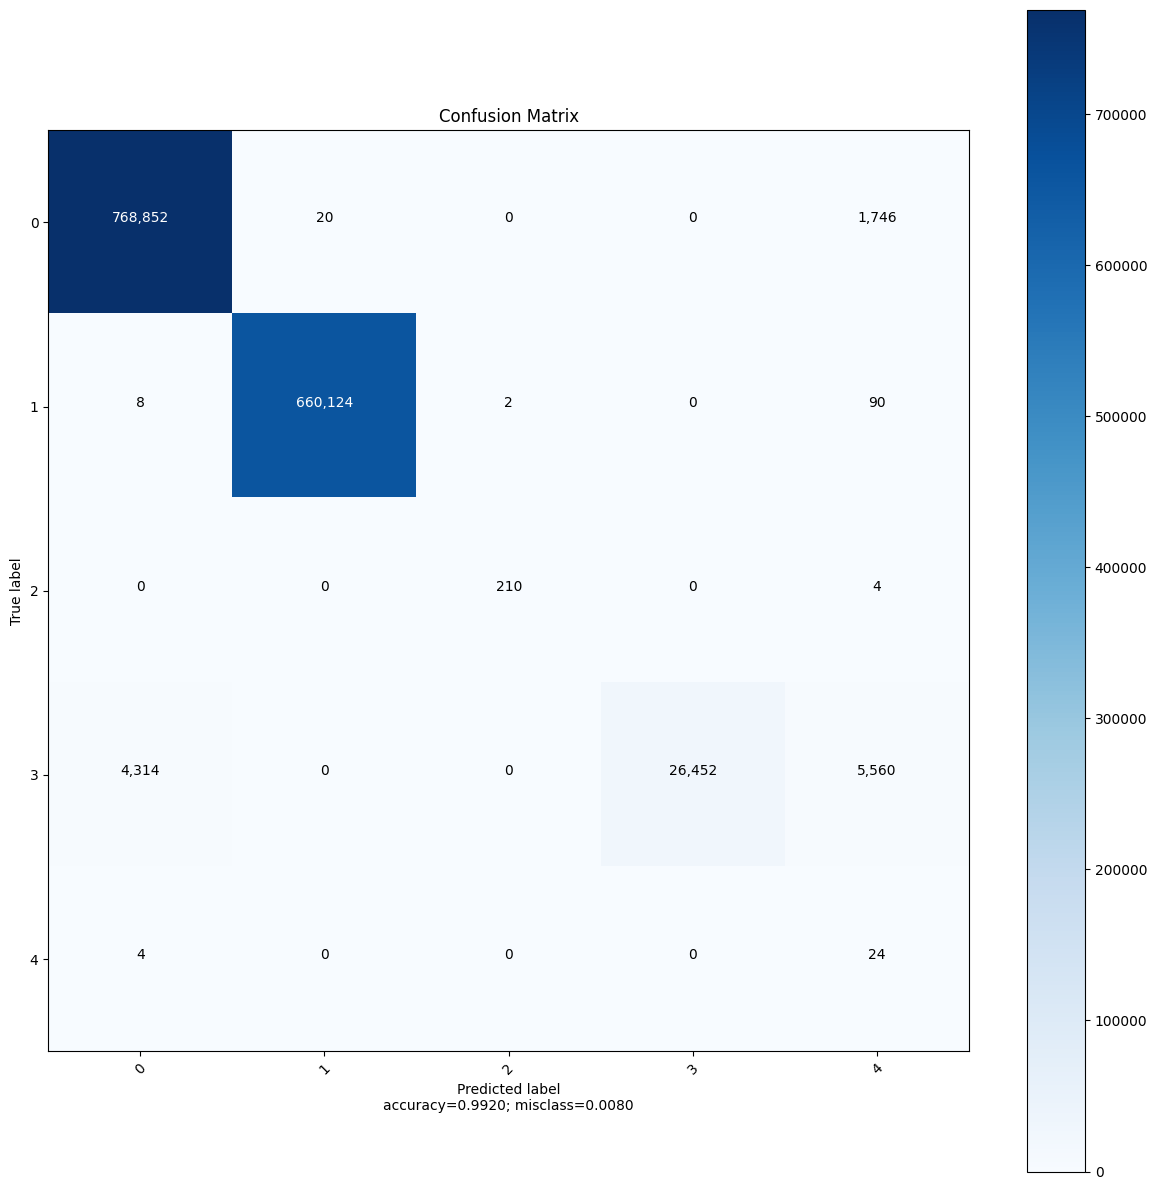

              precision    recall  f1-score   support

           0     0.9944    0.9977    0.9961    770618
           1     1.0000    0.9998    0.9999    660224
           2     0.9906    0.9813    0.9859       214
           3     1.0000    0.7282    0.8427     36326
           4     0.0032    0.8571    0.0064        28

    accuracy                         0.9920   1467410
   macro avg     0.7976    0.9128    0.7662   1467410
weighted avg     0.9970    0.9920    0.9940   1467410



In [ ]:
import numpy as np
import pandas as pd


def plot_confusion_matrix(
    cm, target_names, title="Confusion matrix", cmap=None, normalize=True
):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap("Blues")

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(
                j,
                i,
                "{:0.4f}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )
        else:
            plt.text(
                j,
                i,
                "{:,}".format(cm[i, j]),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel(
        "Predicted label\naccuracy={:0.4f}; misclass={:0.4f}".format(accuracy, misclass)
    )
    plt.show()


from sklearn.metrics import confusion_matrix

print("target_names", np.unique(actual))
plot_confusion_matrix(
    cm=confusion_matrix(actual, test_pred),
    normalize=False,
    target_names=np.unique(actual),
    title="Confusion Matrix",
)

from sklearn.metrics import classification_report

print(classification_report(actual, test_pred, digits=4))
report = classification_report(actual, test_pred, digits=4, output_dict=True)
df = pd.DataFrame(report).transpose()